# 随机森林算法复现

## 集成学习
集成学习的思想就是将多个机器学习算法集成在一起，使得计算出来的效果要优于单个机器学习算法的效果，正所谓：**三个臭皮匠，顶个诸葛亮**。集成学习中的每一个模型并不是最优的，但是会综合考虑所有模型后的输出结果，其泛化性能要优于单个机器学习器。

如果训练的多个模型是同类的，例如都是决策树或者都是神经网络，则称该集成学习是“同质”的，每一个模型叫做“基学习器”。如果训练的多个模型不是同类的，例如既有决策树又有神经网络，则称该集成学习是异质的，每一个模型称为“个体学习器”。

集成学习一共分为两种，一种是以**bagging**为代表的并行集成学习，也就是说每个学习器之间不存在依赖关系；另一类是以**Boosting**为
代表的串行集成学习，也就是每个学习器之间具有很强的依赖关系。

随机森林算法属于典型的**bagging**算法。

## Bagging算法
Bagging(袋装法)是Bootstrap Aggregating 的缩写，使用同一个数据集，不同的训练集，并且使用相同模型的集成学习算法。

先对数据集进行自助采样，构建多个不同的训练集，之后在每个训练集上构造相应的模型作为基学习器，最后将这些学习器聚合起来得到最终的模型，Bagging算法中两个重要的部分：
- bootstrap 采样：对于m个样本的原始训练集，每次随机采集一个样本放入到采样集，再把该样本放回，这样采集m次，就会得到m个样本集
- 模型聚合：对于分类问题，一般采用投票（Voting）的方法将n个模型的分类结果中出现次数最多的一个作为最终的分类结果；对于回归问题，一般直接取n个模型的输出平均值。

In [1]:
import random
from sklearn.ensemble import RandomForestClassifier
from math import *
import numpy as np
from collections import Counter
import pandas as pd
from sklearn.model_selection import train_test_split
import utils
from sklearn.utils import resample
from sklearn.metrics import classification_report,accuracy_score

In [2]:
# 决策树类
import numpy as np 
from math import log
from collections import Counter
import random
import utils
import heapq
### CART算法的节点类
class Node:
    def __init__(self, feature, threshold, left, right):
        self.feature = feature
        self.threshold = threshold
        self.left = left
        self.right = right
## 这里随机森林中的决策树默认使用CART算法，即gini指数
class DecisionTreeClassify():
    def __init__(self,random_state=42,criterion='gini',max_depth=99999, min_samples_split=2,min_samples_leaf = 1,Post_prune=True,train_size =0.75) -> None:
        self.choose_tree ={} 
        self.max_depth = max_depth ## 树的最大深度,属于预剪枝操作
        self.min_samples_split = min_samples_split ##节点的样本数量最小的阈值，如果小于该值则停止生长，属于预剪枝操作
        self.min_samples_leaf = min_samples_leaf #表示叶节点所需的最小样本数，默认为 1。
        self.criterion = criterion ##用户自己选择的算法：'ID3'、'C45'、'CART' ,默认CART算法
        self.randseed = random_state  ##随机数种子
        self.Post_prune = Post_prune ##后剪枝，默认为True
        self.train_size = train_size ##后剪枝中训练集的样本比例，默认为0.75
    
    ## 计算基尼指数
    def _gini_impurity(self, y):
        m = len(y)
        return 1.0 - sum([(np.sum(y == c) / m) ** 2 for c in np.unique(y)])

    
    ## 定义统计出现标签出现次数最多的种类
    def result_y(self,y):
        label = Counter(y)
        sort = heapq.nlargest(1, label.items(), key=lambda x: x[1])
        return sort[0][0]
    ## 首先基于数据集D基尼指数、然后计算特征向量feature中值为threshold的基尼指数，二者相减，计算增量
    def _gini_gain(self, y, feature, threshold):
        parent_gini = self._gini_impurity(y) ##计算当前数据集的基尼指数
        left_idxs = np.argwhere(feature<= threshold).flatten() ##计算特征feature=threshold的行索引
        right_idxs = np.argwhere(feature>threshold).flatten() ##计算特征feature！=threshold的行索引
        if len(left_idxs) == 0 or len(right_idxs) == 0: ##如果有一个行索引是空的，意味着特征的值种类只有一个
            return 0
        left_gini = self._gini_impurity(y[left_idxs]) #计算划分数据集后的数据集D1的基尼指数
        right_gini = self._gini_impurity(y[right_idxs]) ##计算D-D1数据集的基尼指数
        p_left = len(left_idxs) / len(y)
        p_right = 1 - p_left
        child_gini = p_left * left_gini + p_right * right_gini
        return parent_gini - child_gini         
    
    ## 定义后剪枝算法函数
    def post_prune(self, tree, X_val, y_val):
        if not isinstance(tree,Node): #如果此时的树是叶节点,则返回当前的叶节点即可
            return tree
        n_samples = X_val.shape[0] #获取验证集的样本数量
        left_tree = tree.left #二叉树的左分枝
        right_tree = tree.right #二叉树的右分枝
        #如果二叉树的左分枝或者右分枝不是属于Node类的话，在进行递归运算，进行剪枝
        if isinstance(tree,Node):
            left_tree = self.post_prune(left_tree,X_val,y_val)
        if isinstance(tree,Node):
            right_tree = self.post_prune(right_tree,X_val,y_val)
        
        # 模拟剪枝前后的准确率，选择最优决策树
        y_pre = [self._CART_predict(inputs,tree) for inputs in X_val]
        tree_accuracy = np.sum([y_pre[i] == y_val[i] for i in range(n_samples)]) / n_samples
        left_accuracy = np.sum([self._CART_predict(X_val[i], left_tree) == y_val[i] for i in range(n_samples)]) / n_samples
        right_accuracy = np.sum([self._CART_predict(X_val[i], right_tree) == y_val[i] for i in range(n_samples)]) / n_samples
        accuracy_before_pruning = tree_accuracy # 剪枝之前的准确率
        
        cut_left = True
        if left_accuracy>right_accuracy:
            accuracy_after_pruning = left_accuracy
        else:
            accuracy_after_pruning = right_accuracy
            cut_left = False
            
        if accuracy_after_pruning>accuracy_before_pruning and cut_left: #如果左分支剪枝后的准确率大于剪枝之前的准确率
            return self.result_y(y_val)
        elif accuracy_after_pruning >accuracy_after_pruning and not cut_left:
            return self.result_y(y_val)
        else:
            return Node(tree.feature,tree.threshold,tree.left,tree.right)
        
    ## 生成 CART决策树
    def CART_CreateTree(self, X, y, depth=0): ## X是数据特征，y是标签
        n_samples,n_features = X.shape ##获取数据特征的个数
        n_labels = len(np.unique(y)) #获取因变量的种类个数

        if depth >= self.max_depth or n_labels == 1 or n_samples<self.min_samples_split: ##如果二叉树的分支大于默认的最大分支个数或者因变量的标签种类个数为1
            return self.result_y(y) ##返回标签中样本数最多的类别

        best_gain = -1
        best_feature = -1
        for feature_idx in range(n_features): ## 遍历每一个特征
            # for threshold in np.unique(X[:, feature_idx]):#遍历特征向量的每一个不同的取值
            thresholds = np.unique(X[:,feature_idx])
            gains = np.array([self._gini_gain(y, X[:, feature_idx], t) for t in thresholds])
            max_gain_idx = np.argmax(gains)
            if gains[max_gain_idx] > best_gain:
                best_gain = gains[max_gain_idx]  ##选择增益最大的
                best_feature = feature_idx ##增益最大相应的特征索引
                best_threshold = thresholds[max_gain_idx] ##相应的最优切分点

        left_idxs = np.argwhere(X[:,best_feature] <=best_threshold).flatten() 
        right_idxs = np.argwhere(X[:,best_feature]>best_threshold).flatten()
        if len(left_idxs) <self.min_samples_leaf or len(right_idxs) <self.min_samples_leaf:
            return self.result_y(y)
        left_tree = self.CART_CreateTree(X[left_idxs, :], y[left_idxs], depth + 1) ##递归生成二叉树的左侧部分
        right_tree = self.CART_CreateTree(X[right_idxs, :], y[right_idxs], depth + 1) ##递归生成二叉树的右侧部分
        return Node(best_feature, best_threshold, left_tree, right_tree) ##将最优特征与最优切分点、二叉树左侧、二叉树右侧存入Node类
    
    def _CART_predict(self,inputs,tree): ##用于后剪枝算法使用的预测函数
        node = tree
        while isinstance(node,Node):
            if inputs[node.feature]<=node.threshold:
                node = node.left
            else:
                node = node.right
        return node
    
    def CART_predict(self, inputs): 
        node = self.choose_tree
        while isinstance(node, Node):
            if inputs[node.feature] <= node.threshold:
                node = node.left
            else:
                node = node.right
        return node  
    

    # 定义训练函数
    def fit(self,X_train,y_train):
        self.labels = np.unique(y_train)
        if self.Post_prune: ##如果进行后剪枝
             # 训练集：验证集：测试集 = 6:2:2 默认值
            train_size = int(self.train_size*X_train.shape[0])
            X_train_ = X_train[:train_size,:]
            y_train_ = y_train[:train_size]
            X_val = X_train[train_size:,:]
            y_val = y_train[train_size:]
            tree = self.CART_CreateTree(X_train_,y_train_)
            self.choose_tree = self.post_prune(tree,X_val=X_val,y_val=y_val)
        else: ##如果不进行后剪枝
            self.choose_tree = self.CART_CreateTree(X_train,y_train)
        return self.choose_tree      
    ## 定义预测函数
    def predict(self,X_test):
        classLabel =[]
        classLabel = [self.CART_predict(inputs) for inputs in X_test]
        return np.array(classLabel)

In [3]:
# 随机森林类
import atexit
import celery
from celery import group
class Random_Forest:
    
    def __init__(self,random_state=40,n_estimators=100,max_features=4) -> None:
        self.random_state = random_state ##设置随机数种子，以便能够复现结果
        self.n_estimators = n_estimators ##决策树的个数默认设置为50棵
        self.max_features = max_features ## 每个节点在决策树中随机选择的特征数量，默认为5
        self.tree = [] ##用来存储每一棵决策树算法生成的决策树
   
    def fit(self,X,y):
        self.max_features = int(sqrt(X.shape[1])) ##每一棵决策树随机选择的特征数量
        n_samples, n_features = X.shape
        random.seed(self.random_state)

        for iter in range(self.n_estimators): ##遍历每一个基学习器
            sample_indices = random.sample(range(n_samples), n_samples)
            feature_indices = random.sample(range(n_features), self.max_features)
            X_sampled = X[sample_indices][:, feature_indices]
            y_sampled = y[sample_indices]
            basic_model = DecisionTreeClassify(Post_prune=False)
            temp_tree =  basic_model.fit(X_sampled,y_sampled)
            self.tree.append((temp_tree,feature_indices))

        return self.tree
    
    def _CART_predict(self,inputs,tree): ##用于后剪枝算法使用的预测函数
        node = tree
        while isinstance(node,Node):
            if inputs[node.feature]<=node.threshold:
                node = node.left
            else:
                node = node.right
        return node
    
    def predict(self,X):
        classLabel = []
        tree = self.tree
        for x_test in X:
            y_pred = []
            for i in range(self.n_estimators):   
                temp_tree =tree[i][0]
                feature_idx = tree[i][1]
                y_pred.append(self._CART_predict(x_test[feature_idx],temp_tree))
            ## 对预测结果进行投票
            count = Counter(y_pred)
            # 找到出现次数最多的元素
            most_common = count.most_common(1)
            classLabel.append(most_common[0][0])
        
        return np.array(classLabel)
            

# 心脏病数据集二分类预测-基于随机森林

In [4]:
data_1 = pd.read_csv('data/heart.csv')
cols = list(data_1.columns)
y = data_1.target
x = data_1.drop('target',axis=1)
X = x.values
y = y.values
X_train_1,X_test_1,y_train_1,y_test_1 = train_test_split(X,y,test_size=0.2,random_state=42)

自编随机森林算法耗时:6.060184s
              precision    recall  f1-score   support

           0       0.99      0.98      0.99       102
           1       0.98      0.99      0.99       103

    accuracy                           0.99       205
   macro avg       0.99      0.99      0.99       205
weighted avg       0.99      0.99      0.99       205

0.9853658536585366


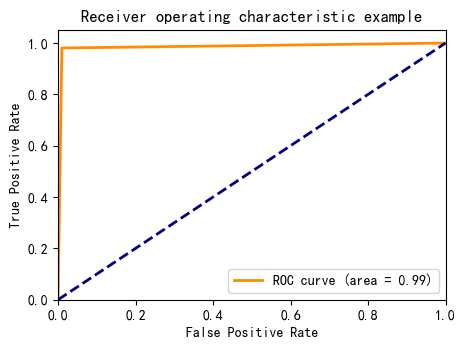

In [5]:
my_model = Random_Forest()
import time
start = time.time()
my_model.fit(X=X_train_1,y=y_train_1)
y_pre = my_model.predict(X_test_1)
end = time.time()
print('自编随机森林算法耗时:{:5f}s'.format(end-start))
print(classification_report(y_true=y_test_1,y_pred=y_pre))   
print(accuracy_score(y_pre,y_test_1))
utils.roc_plot(y_pre,y_test_1)

sklearn官网随机森林算法耗时:0.092071s
              precision    recall  f1-score   support

           0       0.97      1.00      0.99       102
           1       1.00      0.97      0.99       103

    accuracy                           0.99       205
   macro avg       0.99      0.99      0.99       205
weighted avg       0.99      0.99      0.99       205

0.9853658536585366


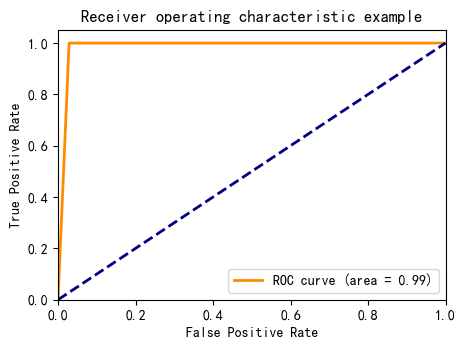

In [6]:
sklearn_model = RandomForestClassifier()
start = time.time()
sklearn_model.fit(X=X_train_1,y=y_train_1)
y_pre_skearn = sklearn_model.predict(X=X_test_1)
end = time.time()
print('sklearn官网随机森林算法耗时:{:5f}s'.format(end-start))
print(classification_report(y_true=y_test_1,y_pred=y_pre_skearn))   
print(accuracy_score(y_pre_skearn,y_test_1))
utils.roc_plot(y_pre_skearn,y_test_1)

# 电离层数据集-自编随机森林算法与sklearn算法比较

自编随机森林算法耗时:67.266212
              precision    recall  f1-score   support

           b       0.86      1.00      0.92        18
           g       1.00      0.94      0.97        52

    accuracy                           0.96        70
   macro avg       0.93      0.97      0.95        70
weighted avg       0.96      0.96      0.96        70

0.9571428571428572


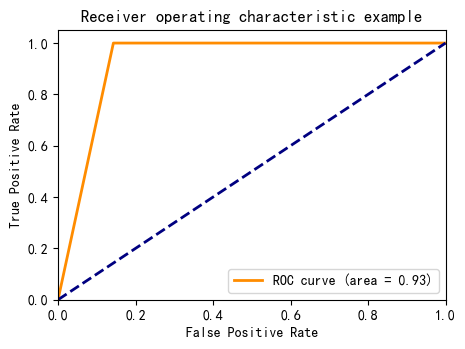

In [7]:
train = pd.read_excel('data/ionosphere_train.xlsx')
train = train.values
test = pd.read_excel('data/ionosphere_test.xlsx')
test = test.values
x_train = train[:,:-1]
y_train = train[:,-1]
x_test = test[:,:-1]
y_test = test[:,-1]
model_1 = Random_Forest()
sklearn_model_1 = RandomForestClassifier()
start = time.time()
model_1.fit(X=x_train,y=y_train)
y_pre1 = model_1.predict(x_test)
end = time.time()
## 自编算法的性能
print('自编随机森林算法耗时:{:5f}s'.format(end-start))
print(classification_report(y_pre1,y_test))
print(accuracy_score(y_pre1,y_test))
map = {'b':0,'g':1}
y_true = [map[i] for i in y_test]
y_pred = [map[i] for i in y_pre1]
utils.roc_plot(y_true,y_pred)


sklearn官网随机森林算法耗时:0.088622s
              precision    recall  f1-score   support

           b       0.86      1.00      0.92        18
           g       1.00      0.94      0.97        52

    accuracy                           0.96        70
   macro avg       0.93      0.97      0.95        70
weighted avg       0.96      0.96      0.96        70

0.9571428571428572


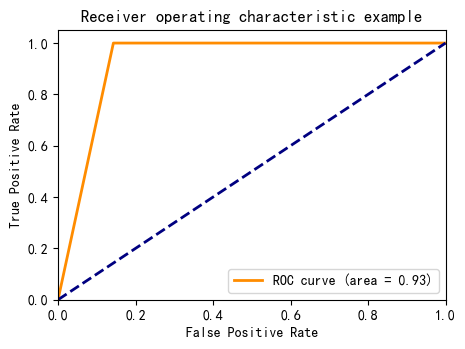

In [8]:
start = time.time()
sklearn_model_1.fit(x_train,y_train)
y_pre_skearn1 = sklearn_model_1.predict(x_test)
end=time.time()
print('sklearn官网随机森林算法耗时:{:5f}s'.format(end-start))
print(classification_report(y_pre1,y_test))
print(accuracy_score(y_pre1,y_test))
map = {'b':0,'g':1}
y_true = [map[i] for i in y_test]
y_pred = [map[i] for i in y_pre1]
utils.roc_plot(y_true,y_pred)

# 乳腺癌数据集预测-自编随机森林算法与sklearn随机森林算法比较

In [9]:
data_2 = pd.read_csv('data/breast_cancer.csv')
data_2 = data_2.values
x = data_2[:,:-1]
y = data_2[:,-1]
x_train2,x_test2,y_train2,y_test2 = train_test_split(x,y,test_size=0.2,random_state=42)
# print(x_train2.shape)
# print(y_train2.shape)

(454, 30)
(454,)


              precision    recall  f1-score   support

         0.0       0.91      0.98      0.94        43
         1.0       0.99      0.94      0.96        71

    accuracy                           0.96       114
   macro avg       0.95      0.96      0.95       114
weighted avg       0.96      0.96      0.96       114

0.956140350877193


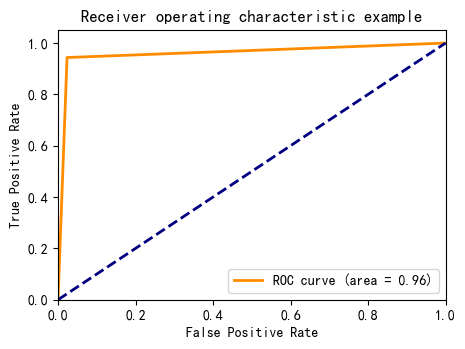

In [10]:
model_2 = Random_Forest()
model_2.fit(x_train2,y_train2)
y_pre2 = model_2.predict(x_test2)
print(classification_report(y_pre2,y_test2))
print(accuracy_score(y_pre2,y_test2))
utils.roc_plot(y_pre2,y_test2)

              precision    recall  f1-score   support

         0.0       0.91      1.00      0.95        42
         1.0       1.00      0.94      0.97        72

    accuracy                           0.96       114
   macro avg       0.96      0.97      0.96       114
weighted avg       0.97      0.96      0.97       114

0.9649122807017544


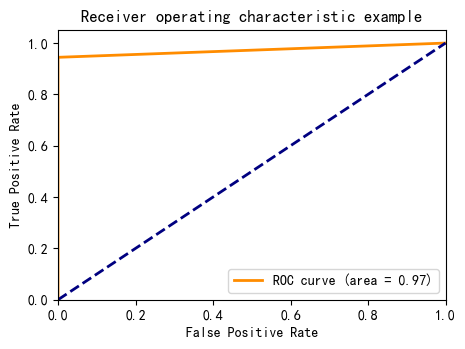

In [11]:
sklearn_model_2 = RandomForestClassifier()
sklearn_model_2.fit(x_train2,y_train2)
y_pre_skearn2 = sklearn_model_2.predict(x_test2)
print(classification_report(y_pre_skearn2,y_test2))
print(accuracy_score(y_pre_skearn2,y_test2))
utils.roc_plot(y_pre_skearn2,y_test2)